In [73]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [74]:
# load the regional / industry data
file_path = 'regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx'

df = pd.read_excel(file_path, sheet_name='Table 1b', header=1)

# Make sure "Region name" exists and extract the unique value of this column
if 'Region name' in df.columns:
    unique_regions = df['Region name'].dropna().unique()
    print("Region name:")
    for region in unique_regions:
        print(region)
else:
    print("The 'Region name' not found")


Region name:
United Kingdom
England
North East
North West
Yorkshire and The Humber
East Midlands
West Midlands
East
London
South East
South West
Wales
Scotland
Northern Ireland
Extra-Regio
United Kingdom less Extra-Regio


In [75]:
# load the pollution data
data_dir = "Dataset_v4"

# pnec value
target_substances = {
    "Copper": 1.0,
    "Cypermethrin":0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Used for storing all annual data
all_years_data = []

# Traverse from 2016 to 2023
for year in range(2016, 2024):
    file_name = f"d{str(year)[-2:]}_v4.csv"
    file_path = os.path.join(data_dir, file_name)

    try:
        df = pd.read_csv(file_path)
        df_filtered = df[df["SUBSTANCE NAME"].isin(target_substances.keys())].copy()
        df_filtered["Year"] = year
        df_filtered["PNEC"] = df_filtered["SUBSTANCE NAME"].map(target_substances)
        df_filtered["Pollution Score"] = df_filtered["QUANTITY RELEASED (kg)"] / df_filtered["PNEC"]

        # Summarize by REGION and SUBSTANCE
        df_grouped = (
            df_filtered.groupby(["Year", "REGION", "SUBSTANCE NAME"])
            .agg({"QUANTITY RELEASED (kg)": "sum", "Pollution Score": "sum"})
            .reset_index()
        )

        all_years_data.append(df_grouped)

    except FileNotFoundError:
        print(f"{file_path} not found")

# merge all years' data
final_df = pd.concat(all_years_data, ignore_index=True)

# Add to the pollution severity ranking
final_df["Rank"] = final_df.groupby(["Year", "SUBSTANCE NAME"])["Pollution Score"]\
                           .rank(method="dense", ascending=False)

# export as csv
final_df.to_csv("pollution_severity_ranked_by_region.csv", index=False)

# output few lines 
print(final_df.head(20))


    Year           REGION          SUBSTANCE NAME  QUANTITY RELEASED (kg)  \
0   2016    East Midlands          Benzo(a)pyrene                  5.9000   
1   2016    East Midlands                  Copper               3550.4800   
2   2016    East Midlands            Cypermethrin                  0.0000   
3   2016    East Midlands            Fluoranthene                  1.6900   
4   2016    East Midlands  Indeno(1,2,3-cd)pyrene                  8.9300   
5   2016  East of England          Benzo(a)pyrene                  4.3200   
6   2016  East of England                  Copper               5500.0000   
7   2016  East of England            Cypermethrin                  0.0000   
8   2016  East of England            Fluoranthene                  1.9700   
9   2016  East of England  Indeno(1,2,3-cd)pyrene                  7.8200   
10  2016           London          Benzo(a)pyrene                 39.6700   
11  2016           London                  Copper              16878.7160   

In [76]:
import pandas as pd
from scipy.stats import pearsonr

# Industrial data
df_income = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1b",
    header=1
)

# Selecte regions
target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]
df_income = df_income[df_income["Region name"].isin(target_regions)]

# Years
years = [str(y) for y in range(2015, 2024)]
df_income_long = df_income.melt(
    id_vars=["Region name", "SIC07 description"],
    value_vars=years,
    var_name="Year",
    value_name="Income"
)
df_income_long.rename(columns={"Region name": "REGION"}, inplace=True)
df_income_long["Year"] = df_income_long["Year"].astype(int)

# substance and PNEC
target_substances = {
    "Copper": 1.0,
    "Cypermethrin": 0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Continuously calculate the industry correlations of each substance
all_corrs = []

for substance, pnec in target_substances.items():
    df_sub = final_df[final_df["SUBSTANCE NAME"] == substance][["REGION", "Year", "Pollution Score"]].copy()
    df_sub["Severity"] = df_sub["Pollution Score"] / pnec

    df_sub_agg = df_sub.groupby(["REGION", "Year"])["Severity"].sum().reset_index()

    df_merge = pd.merge(df_income_long, df_sub_agg, on=["REGION", "Year"], how="inner")

    for industry, group in df_merge.groupby("SIC07 description"):
        if group["Income"].notna().sum() > 5:
            r, p = pearsonr(group["Income"], group["Severity"])
            all_corrs.append({
                "Industry": industry,
                "Pearson_r": r,
                "p_value": p,
                "Substance": substance
            })

df_corr_all = pd.DataFrame(all_corrs)

# Each industry × each substance
df_corr_pivot = df_corr_all.pivot(index="Industry", columns="Substance", values="Pearson_r")

# Sort the average absolute correlation coefficients
df_corr_pivot["Mean_abs_r"] = df_corr_pivot.abs().mean(axis=1)
df_corr_top10 = df_corr_pivot.sort_values(by="Mean_abs_r", ascending=False).head(10)

# Results
print("=== Correlation between Industial × Substance （Top10） ===")
print(df_corr_top10)


=== Correlation between Industial × Substance （Top10） ===
Substance                                          Benzo(a)pyrene  Copper  \
Industry                                                                    
Security and investigation activities                      0.6797  0.9005   
Arts, entertainment and recreation                         0.6379  0.9127   
Professional, scientific and technical activities          0.6177  0.9132   
Services sector                                            0.6326  0.8967   
Employment activities                                      0.6565  0.9098   
Administrative and support service activities              0.6321  0.8782   
All industries                                             0.6349  0.8810   
Travel agency and tour operator activities                 0.6498  0.8446   
Creative, arts and entertainment activities                0.5812  0.9066   
Real estate activities, excluding imputed rental           0.6159  0.9145   

Substance        

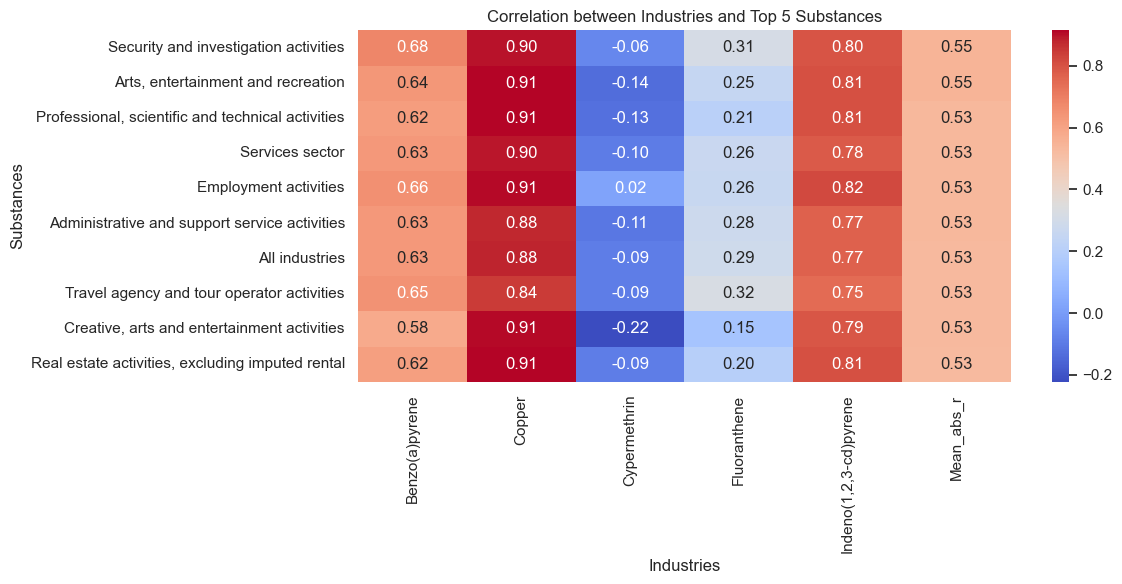

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr_top10, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Industries and Top 5 Substances")
plt.xlabel("Industries")
plt.ylabel("Substances")
plt.tight_layout()
plt.show()


### Correlation analysis

Combined data: r = 0.1298, p = 0.0000


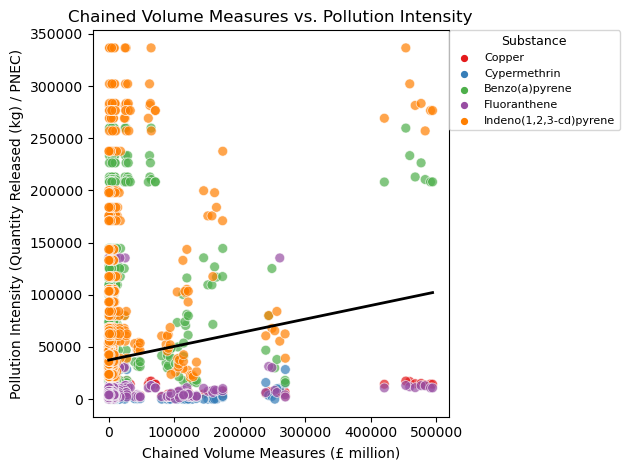

In [77]:
indu_df = df_regi_indu[
    (df_regi_indu["SIC07 description"].isin(target_industries)) &
    (df_regi_indu["Region name"].isin(target_regions))
]

years = [str(y) for y in range(2015, 2024)]
indu_df = indu_df[["Region name"] + years]

indu_long = indu_df.melt(
    id_vars="Region name",
    var_name="Year",
    value_name="Indu_Income"
)
indu_long.columns = ["REGION", "Year", "Indu_Income"]
indu_long["Year"] = indu_long["Year"].astype(int)
indu_long["REGION"] = indu_long["REGION"].str.lower()

# pollution data
pollution_df = final_df[["Year", "REGION", "SUBSTANCE NAME", "QUANTITY RELEASED (kg)"]].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["REGION"] = pollution_df["REGION"].str.strip().str.lower()

#Continuously process the five substances and combine them
all_data = []

for substance, pnec in target_substances.items():
    sub_df = pollution_df[pollution_df["SUBSTANCE NAME"] == substance].copy()
    sub_df["Pollution Intensity"] = sub_df["QUANTITY RELEASED (kg)"] / pnec
    
    sub_sum = sub_df.groupby(["REGION", "Year"])["Pollution Intensity"].sum().reset_index()
    merged = pd.merge(sub_sum, indu_long, on=["REGION", "Year"], how="inner").dropna()
    merged["Substance"] = substance
    all_data.append(merged)

merged_all = pd.concat(all_data, ignore_index=True)

# Remove extreme values (IQR method, for Pollution Intensity)
Q1 = merged_all["Pollution Intensity"].quantile(0.05)
Q3 = merged_all["Pollution Intensity"].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR
merged_all = merged_all[(merged_all["Pollution Intensity"] >= lower_bound) &
                        (merged_all["Pollution Intensity"] <= upper_bound)]

# Different substances have different colors, 
# but there is only one comprehensive regression line
sns.scatterplot(
    x="Indu_Income", 
    y="Pollution Intensity", 
    hue="Substance",
    data=merged_all,
    palette="Set1",
    s=50,
    alpha=0.7
)

# A single regression line (based on all substance data)
sns.regplot(
    x="Indu_Income",
    y="Pollution Intensity",
    data=merged_all,
    scatter=False,
    ci=None,
    color="black",
    line_kws={"linewidth": 2}
)


# Pearson Correlation coefficient (combined data)
r, p = pearsonr(merged_all["Indu_Income"], merged_all["Pollution Intensity"])
print(f"Combined data: r = {r:.4f}, p = {p:.4f}")

plt.title("Chained Volume Measures vs. Pollution Intensity")
plt.xlabel("Chained Volume Measures (£ million)")
plt.ylabel("Pollution Intensity (Quantity Released (kg) / PNEC)")

# Legend
plt.legend(
    title="Substance",
    bbox_to_anchor=(1, 1),  
    borderaxespad=0,
    markerscale=0.7,  
    fontsize=8,      
    title_fontsize=9  
)


plt.tight_layout()
plt.show()


### Regression

In [78]:
import statsmodels.api as sm

X = merged_all["Indu_Income"]

y = merged_all["Pollution Intensity"]

# constant
X_const = sm.add_constant(X)
# OLS regression
model = sm.OLS(y, X_const).fit()

print(model.summary())

# coeff
intercept = model.params["const"]
slope = model.params["Indu_Income"]

# print the equation
print("\nRegression Equation：")
print(f"Pollution Intensity = {intercept:.6f} + {slope:.6f} * Chained Volume Measures")

# Print the goodness of fit
print(f"\nR-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")


                             OLS Regression Results                            
Dep. Variable:     Pollution Intensity   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     46.54
Date:                 Sat, 16 Aug 2025   Prob (F-statistic):           1.10e-11
Time:                         12:31:11   Log-Likelihood:                -33963.
No. Observations:                 2718   AIC:                         6.793e+04
Df Residuals:                     2716   BIC:                         6.794e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.745e+04   1317.073     28

Regional-level regression:
  Pearson r = 0.0838
  p-value   = 8.4362e-01
  Significant? No
  Regression equation: Pollution_Intensity = 25256298.2401 + 0.3197 * Indu_Income
                             OLS Regression Results                            
Dep. Variable:     Pollution_Intensity   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                 -0.158
Method:                  Least Squares   F-statistic:                   0.04243
Date:                 Sat, 16 Aug 2025   Prob (F-statistic):              0.844
Time:                         12:40:13   Log-Likelihood:                -150.52
No. Observations:                    8   AIC:                             305.0
Df Residuals:                        6   BIC:                             305.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    s

/Users/macbookair/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


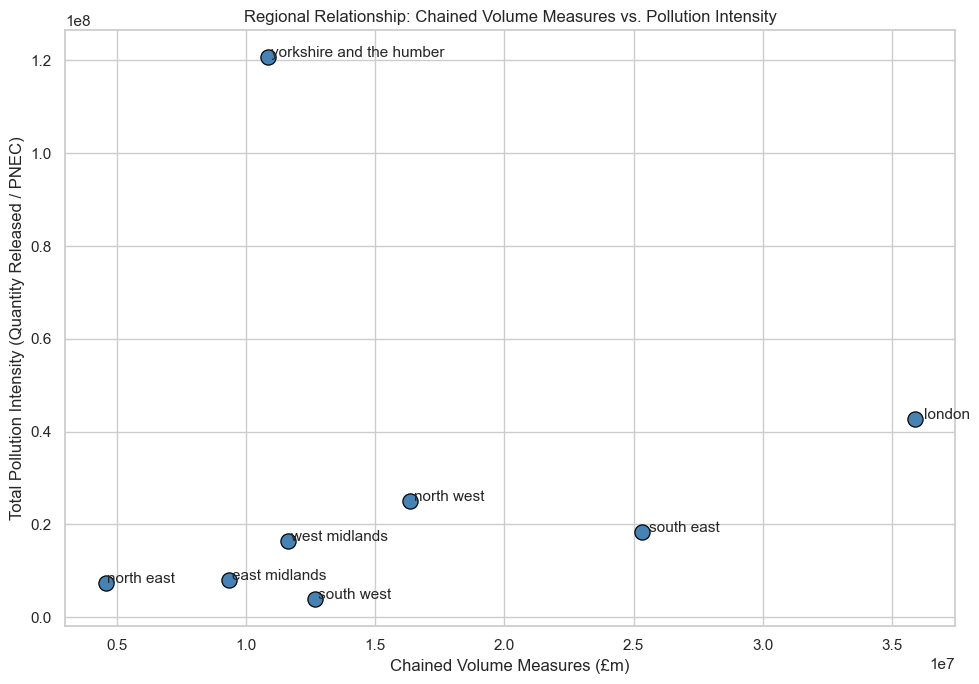

In [88]:
import statsmodels.api as sm
from scipy.stats import pearsonr

# 计算区域层面的 Pollution Intensity
merged_df["Pollution_Intensity"] = merged_df["QUANTITY RELEASED (kg)"] / merged_df["PNEC"]

# 按 REGION 聚合
region_summary = merged_df.groupby("REGION").agg({
    "Pollution_Intensity": "sum",
    "Indu_Income": "sum"
}).reset_index()

# ---------------------------
# 统计分析
# ---------------------------
x = region_summary["Indu_Income"]
y = region_summary["Pollution_Intensity"]

# Pearson 相关性
r, p_value = pearsonr(x, y)

# OLS 回归
X_const = sm.add_constant(x)
model = sm.OLS(y, X_const).fit()

# 打印结果
print("Regional-level regression:")
print(f"  Pearson r = {r:.4f}")
print(f"  p-value   = {p_value:.4e}")
print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'}")
print("  Regression equation: Pollution_Intensity = "
      f"{model.params['const']:.4f} + {model.params['Indu_Income']:.4f} * Indu_Income")
print(model.summary())

# ---------------------------
# 可视化 (无拟合线)
# ---------------------------
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    data=region_summary,
    x="Indu_Income",
    y="Pollution_Intensity",
    s=120,
    color="steelblue",
    edgecolor="black"
)

# 标注区域名
for i, row in region_summary.iterrows():
    plt.text(
        row["Indu_Income"] * 1.01,
        row["Pollution_Intensity"],
        row["REGION"],
        fontsize=11
    )

plt.xlabel("Chained Volume Measures (£m)")
plt.ylabel("Total Pollution Intensity (Quantity Released / PNEC)")
plt.title("Regional Relationship: Chained Volume Measures vs. Pollution Intensity")
plt.tight_layout()
plt.show()
